In [1]:
import pandas as pd
import numpy as np

import re

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from transformers import RobertaTokenizer
from transformers import RobertaForSequenceClassification
from transformers import get_scheduler

import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler

from tqdm import tqdm

import time

In [2]:
# =====================================================
# Setup
# =====================================================
path = "/kaggle/input/tweetsdata/training.1600000.processed.noemoticon.csv"

# Load the dataset
data = pd.read_csv(path, encoding="latin-1", header=None)

# Rename columns for clarity
data.columns = ["target", "ids", "date", "flag", "user", "text"]

Text(0.5, 1.0, 'Happiness Score Distribution')

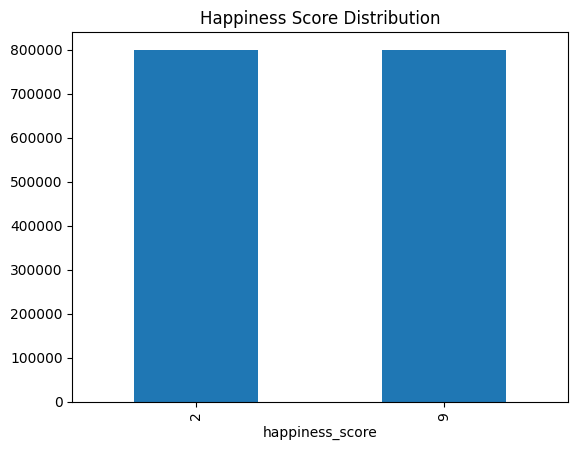

In [3]:
# =====================================================
# Preprocessing
# =====================================================
def map_target_to_happiness(target):
    if target == 0:
        return 2  # Example score for negative sentiment
    elif target == 2:
        return 5  # Neutral sentiment
    else:
        return 9  # Positive sentiment


data["happiness_score"] = data["target"].apply(map_target_to_happiness)

def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"#\w+", "", text)  # Remove hashtags
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters
    text = text.lower().strip()  # Convert to lowercase
    return text


data["cleaned_text"] = data["text"].apply(clean_text)
data = data[["happiness_score", "cleaned_text"]]
# Display dataset information
# print(data.head())

# Visualization
data["happiness_score"].value_counts().plot(kind="bar")
plt.title("Happiness Score Distribution")
# plt.show()


In [4]:
# =====================================================
# Data Sampling
# =====================================================
# Reduce dataset to 100 rows for testing
data_sample = data.sample(n=100, random_state=42)  # Randomly sample 100 rows


In [5]:
# =====================================================
# Preparing training set
# =====================================================
X = data["cleaned_text"].values  # Feature: text data
y = data["happiness_score"].values  # Target: happiness score

# Split into training and temp sets (80% training, 20% for validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split temp set into validation and test (50-50 split)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [6]:
# =====================================================
# Tokenization and Text Vectorization
# =====================================================
# Load pre-trained RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")


# Tokenize text data
def tokenize_data(texts, tokenizer, max_length=128):
    return tokenizer(
        list(texts),
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )


# Apply tokenization to your dataset
train_encodings = tokenize_data(X_train, tokenizer)
val_encodings = tokenize_data(X_val, tokenizer)
test_encodings = tokenize_data(X_test, tokenizer)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
# =====================================================
# Create Dataset class
# =====================================================
class HappinessDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

# Create datasets
train_dataset = HappinessDataset(train_encodings, y_train)
val_dataset = HappinessDataset(val_encodings, y_val)
test_dataset = HappinessDataset(test_encodings, y_test)


In [8]:
# =====================================================
# Load the Pre-Trained RoBERTa Model
# =====================================================

# Load pre-trained RoBERTa model for regression
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=1  # Single output for regression
)
# Wrap the model with DataParallel for multi-GPU support
model = torch.nn.DataParallel(model)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# =====================================================
# Create DataLoaders
# =====================================================
train_loader = DataLoader(train_dataset, batch_size=128, num_workers=4, pin_memory=True, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, num_workers=4, pin_memory=True, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, num_workers=4, pin_memory=True, shuffle=False)

In [10]:
# =====================================================
# Setting up training params
# =====================================================

optimizer = AdamW(model.parameters(), lr=5e-5)

num_training_steps = len(train_loader) * 3
scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [11]:
# =====================================================
# Training Phase
# =====================================================

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using device:", device)
model.to(device)
loss_fn = torch.nn.MSELoss().to(device)  # loss function: Mean Squared Error (MSE) for regression task

# Initialize GradScaler for mixed precision
scaler = GradScaler()

train_losses, val_losses = [], []  # Track losses

def train_model(model, train_loader, val_loader, optimizer, loss_fn, scheduler, epochs=3):
    best_val_loss = float('inf')  # Initialize the best validation loss
    patience = 3  # Number of epochs to wait for improvement
    epochs_without_improvement = 0  # Counter for early stopping
    
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # ---- Training Phase ----
        model.train()
        train_loss = 0

        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            batch = {key: val.to(device) for key, val in batch.items()}

            # Mixed precision training (if applied)
            with torch.cuda.amp.autocast():
                outputs = model(**batch)
                loss = loss_fn(outputs.logits.squeeze(-1), batch["labels"])

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            scheduler.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Train Loss: {avg_train_loss}")

        # ---- Validation Phase ----
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = {key: val.to(device) for key, val in batch.items()}

                with torch.cuda.amp.autocast():
                    outputs = model(**batch)
                    loss = loss_fn(outputs.logits.squeeze(-1), batch["labels"])
                    val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Validation Loss: {avg_val_loss}")

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0
            torch.save(model.module.state_dict(), "best_model.pt")  # Save the best model
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print("Early stopping triggered")
                break

    return train_losses, val_losses  # Return losses for visualization



train_model(model, train_loader, val_loader, optimizer, loss_fn, scheduler)


Using device: cuda


/tmp/ipykernel_23/462011618.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/3


  0%|          | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_23/462011618.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 10000/10000 [1:16:35<00:00,  2.18it/s]

Train Loss: 5.182362526321411



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/tmp/ipykernel_23/462011618.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 4.646829110431671
Epoch 2/3


100%|██████████| 10000/10000 [1:16:22<00:00,  2.18it/s]

Train Loss: 4.245276401531696


Validation Loss: 4.4363785705566405
Epoch 3/3


100%|██████████| 10000/10000 [1:16:24<00:00,  2.18it/s]

Train Loss: 3.5878139496564865


Validation Loss: 4.4585425309181215


([5.182362526321411, 4.245276401531696, 3.5878139496564865],
 [4.646829110431671, 4.4363785705566405, 4.4585425309181215])

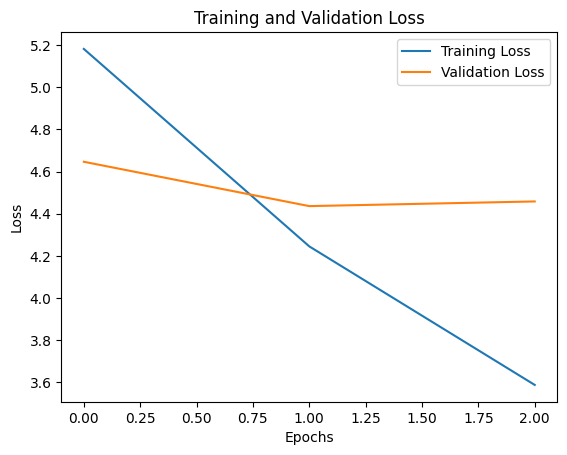

In [12]:
# Visualization
# Plot losses
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Test Mean Squared Error (MSE): 4.4487
Test R² Score: 0.6368


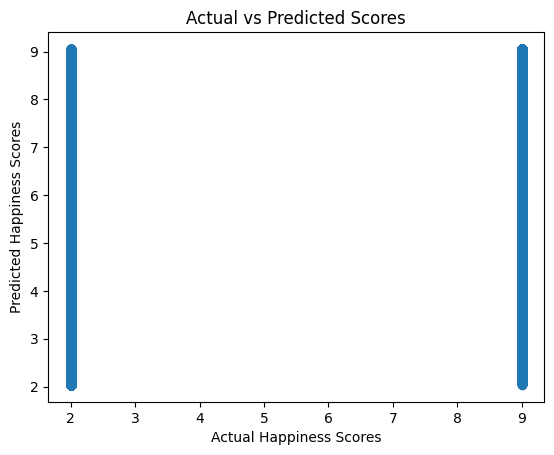

In [13]:
# =====================================================
# Evaluation Phase
# =====================================================

def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            batch = {key: val.to(device) for key, val in batch.items()}
            outputs = model(**batch)
            preds = outputs.logits.squeeze(-1).cpu().numpy()
            labels = batch["labels"].cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)

    # Compute metrics
    mse = mean_squared_error(all_labels, all_preds)
    r2 = r2_score(all_labels, all_preds)

    print(f"Test Mean Squared Error (MSE): {mse:.4f}")
    print(f"Test R² Score: {r2:.4f}")

    # Plot predictions vs actual
    plt.scatter(all_labels, all_preds, alpha=0.5)
    plt.xlabel("Actual Happiness Scores")
    plt.ylabel("Predicted Happiness Scores")
    plt.title("Actual vs Predicted Scores")
    plt.show()



evaluate_model(model, test_loader)

In [14]:
# =====================================================
# Save Model Phase
# =====================================================
# Save the model weights (state_dict)
torch.save(model.state_dict(), "/kaggle/working/roberta_happiness_model.pt")

# Save the model and tokenizer (unwrap DataParallel)
model.module.save_pretrained("/kaggle/working/roberta_happiness_model")
tokenizer.save_pretrained("/kaggle/working/roberta_happiness_model")

('/kaggle/working/roberta_happiness_model/tokenizer_config.json',
 '/kaggle/working/roberta_happiness_model/special_tokens_map.json',
 '/kaggle/working/roberta_happiness_model/vocab.json',
 '/kaggle/working/roberta_happiness_model/merges.txt',
 '/kaggle/working/roberta_happiness_model/added_tokens.json')

In [15]:
import os
print("Number of CPU cores:", os.cpu_count())


Number of CPU cores: 4
